In [1]:
import os
import pandas as pd
from gplearn.genetic import SymbolicRegressor
from sklearn.utils.random import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn import metrics
from sympy import *
import pickle
from Fancy_aggregations import owas, integrals
from plotnine import ggplot, aes, geom_hline, geom_boxplot,  labs, geom_segment, coord_cartesian
import numpy as np

import warnings
warnings.filterwarnings('ignore')


In [2]:
def generate_plot(data,name):
    #age_mean=np.mean(data['Age'])
    p = (ggplot(data, aes(x='Age', y='prediction', group='Age'))
       # + geom_hline(yintercept=age_mean, color='black', linetype='dashed')
        + geom_boxplot(color='steelblue', fill='lightblue')
        + labs(x='Actual Age', y='Estimated Age', title=name+' - Prediction Performance')
        + geom_segment(aes(x=min(data['Age']), y=min(data['Age']), xend=max(data['Age']), yend=max(data['Age'])),
                        linetype='dotted', color='black')
        + coord_cartesian(xlim=(min(data['Age']), max(data['Age'])), ylim=(min(data['Age']), max(data['Age']))))
    return p

## Read & Process Data, cleanup NAs, save clean data

In [3]:
def extract_dataframes(file_path):
    xls = pd.ExcelFile(file_path)
    sheet_names = xls.sheet_names
    dfs = {}
    for sheet_name in sheet_names:
        df = xls.parse(sheet_name)
        dfs[sheet_name] = df
    xls.close()
    return dfs,sheet_names

file_path =  './data_updated.xlsx'
data_dir=os.path.dirname(file_path) 
result,sheet_names = extract_dataframes(file_path)

In [4]:
def process_dataframes_and_filter_na(result_dataframes,sheet_names):
    processed_dfs = {}
    for sheet_name, df in result_dataframes.items():
        filtered_df = df[df.apply(lambda row: any(pd.isna(cell) or cell == '-' for cell in row), axis=1)]
        processed_dfs[sheet_name] = filtered_df[['id','Laterality']]
    return processed_dfs

def clean_results(result_dataframes,query_dataframe,sheet_names):
    clean_dfs = {}
    for sheet_name, df in result_dataframes.items():
        merged_df = pd.merge(df, query_dataframe, on=['id', 'Laterality'], how='left', indicator=True)
        merged_df = merged_df.drop(merged_df[merged_df.Age > 60].index)
        merged_df = merged_df.drop(merged_df[merged_df.Age < 18].index)
        merged_df = merged_df.drop(merged_df[merged_df.id.isin([514])].index)

        clean_dfs[sheet_name] = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1).astype('int64')
        
    return clean_dfs

processed_dataframes = process_dataframes_and_filter_na(result,sheet_names)
concatenated_df = pd.concat(processed_dataframes.values(), ignore_index=True)
joined_dataframe = concatenated_df.drop_duplicates() 
clean_result_dfs=clean_results(result,joined_dataframe,sheet_names)
with pd.ExcelWriter(os.path.join(data_dir,"clean_data_after_processing.xlsx")) as writer:    
    for sheet_name, df in clean_result_dfs.items():
        df.to_excel(writer,sheet_name=sheet_name,index=False)

## Data Partition 1.0

In [5]:
#Prepare indexes
for sheet_name, df in clean_result_dfs.items():
    clean_result_dfs[sheet_name]=clean_result_dfs[sheet_name].reset_index(drop=True)
for sheet_name, df in clean_result_dfs.items():
    clean_result_dfs[sheet_name]=clean_result_dfs[sheet_name].reset_index()
    
#Taking indexes from E1 labels and splitting
X_idx=clean_result_dfs['E1']['index']
y_idx=clean_result_dfs['E1']['Age']
X_idx_train, X_idx_test, y_idx_train, y_idx_test = train_test_split(X_idx, y_idx, test_size=0.2, random_state=1, stratify=y_idx)



In [6]:
#Slice each dataframe using splitted indexes to avoid data contamination
training_data= {}
testing_data= {}
for sheet_name, df in clean_result_dfs.items():
    training_data[sheet_name]=clean_result_dfs[sheet_name][clean_result_dfs[sheet_name]['index'].isin(X_idx_train)]
    testing_data[sheet_name]=clean_result_dfs[sheet_name][clean_result_dfs[sheet_name]['index'].isin(X_idx_test)]

#Aggregate data
frames_train = [f for s,f in training_data.items()]
frames_test = [f for s,f in testing_data.items()]
training_agg=pd.concat(frames_train)
testing_agg=pd.concat(frames_test)

training_exp=pd.concat([training_data['E1'],training_data['E2']])
testing_exp=pd.concat([testing_data['E1'],testing_data['E2']])

In [7]:
#Verify Stats are correct when aggregated - not essential
frames_agg=[training_agg,testing_agg]
#frames_agg=[training_agg,testing_agg]
agg_all_data=pd.concat(frames_agg)

agg_all_data=agg_all_data.sort_values(by=['id', 'Laterality'])
agg_all_data=agg_all_data.reset_index(drop=True)

print("Size Aggregation: ",  len(agg_all_data))
print("Lateralidad 0: ", len(agg_all_data[agg_all_data['Laterality']==0]))
print("Lateralidad 1: ", len(agg_all_data[agg_all_data['Laterality']==1]))


Size Aggregation:  3944
Lateralidad 0:  1973
Lateralidad 1:  1971


# PG Logic for basic experiments

In [8]:

def fit_SR_model(X_train, y_train,function_set):
    est_gp = SymbolicRegressor(population_size=1000, function_set=function_set, metric='mse',
                            generations=1000, tournament_size=80, stopping_criteria=0.01,
                            p_crossover=0.75, p_subtree_mutation=0.11,
                            p_hoist_mutation=0.08, p_point_mutation=0.05,
                            max_samples=1, verbose=1,
                            parsimony_coefficient=0.05, random_state=0)
    est_gp.fit(X_train, y_train)
    return est_gp

In [9]:

rng = check_random_state(0)
data_eval={'X_train':{},'y_train':{},'X_test':{},'y_test':{}}
for sheet_name, df in training_data.items():
    # Training samples
    data_eval['X_train'][sheet_name] = training_data[sheet_name].drop(columns=['index','id','Laterality','Phase','Age'])
    data_eval['y_train'][sheet_name] = training_data[sheet_name]['Age']

    # Testing samples
    data_eval['X_test'][sheet_name] = testing_data[sheet_name].drop(columns=['index','id','Laterality','Phase','Age'])
    data_eval['y_test'][sheet_name] = testing_data[sheet_name]['Age']

#shuffle
training_agg = training_agg.sample(frac = 1)
testing_agg = testing_agg.sample(frac = 1)

training_exp = training_exp.sample(frac = 1)
testing_exp = testing_exp.sample(frac = 1)

data_eval['X_train']['Agg_data'] = training_agg.drop(columns=['index','id','Laterality','Phase','Age'])
data_eval['y_train']['Agg_data'] = training_agg['Age']

# Testing samples
data_eval['X_test']['Agg_data'] = testing_agg.drop(columns=['index','id','Laterality','Phase','Age'])
data_eval['y_test']['Agg_data'] = testing_agg['Age']

data_eval['X_train']['Expert_data'] = training_exp.drop(columns=['index','id','Laterality','Phase','Age'])
data_eval['y_train']['Expert_data'] = training_exp['Age']

# Testing samples
data_eval['X_test']['Expert_data'] = testing_exp.drop(columns=['index','id','Laterality','Phase','Age'])
data_eval['y_test']['Expert_data'] = testing_exp['Age']

In [15]:
function_set = ['add', 'sub', 'mul', 'div','neg','inv']
SR_models={}
SR_test_results={}
SR_test_predictions={}
SR_train_results={}

for sheet_name, df in  data_eval['X_train'].items():
   SR_models[sheet_name]=fit_SR_model( data_eval['X_train'][sheet_name], data_eval['y_train'][sheet_name] ,function_set)

   y_test_SR=SR_models[sheet_name].predict(data_eval['X_test'][sheet_name])
   test_metric_mae=metrics.mean_absolute_error(data_eval['y_test'][sheet_name],y_test_SR)
   test_metric_rmse=metrics.mean_squared_error(data_eval['y_test'][sheet_name],y_test_SR,squared=False)
   test_score= SR_models[sheet_name].score(data_eval['X_test'][sheet_name],data_eval['y_test'][sheet_name])
   SR_train_results[sheet_name]={'R2_score':SR_models[sheet_name].score(data_eval['X_train'][sheet_name],data_eval['y_train'][sheet_name])}
   SR_test_results[sheet_name]={'R2_score':test_score,'mae':test_metric_mae,'rmse':test_metric_rmse}
   SR_test_predictions[sheet_name]=y_test_SR

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    14.78          13723.9        4          367.494              N/A      5.14m
   1    24.22          2204.83       14          138.068              N/A      5.85m
   2    17.33          15663.9       19          101.809              N/A      5.69m
   3    13.92          7662.41       30          94.4042              N/A      5.52m
   4    19.86          8583.19       23           87.266              N/A      6.34m
   5    23.77             7061       20          84.2525              N/A      6.42m
   6    24.00          7524.45       20          80.3229              N/A      6.42m
   7    22.33          11345.5       25          76.8419              N/A      5.75m
   8    23.37          8249.07       27          75.2128              N/A  

In [16]:
for sheet_name, df in  data_eval['X_train'].items():
    with open('models/'+sheet_name+'.pkl', 'wb') as f:
        pickle.dump(SR_models[sheet_name], f)

### OPTIONAL: LOADING MODELS FROM FILE

In [10]:
SR_models={}
SR_test_results={}
SR_test_predictions={}
SR_train_results={}
for sheet in ['E1','E2','S1','S2','Agg_data','Expert_data']:
    with open('models/'+sheet+'.pkl', 'rb') as f:
        est = pickle.load(f)
        SR_models[sheet]=est


for sheet_name, df in  data_eval['X_train'].items():
   y_test_SR=SR_models[sheet_name].predict(data_eval['X_test'][sheet_name])
   test_metric_mae=metrics.mean_absolute_error(data_eval['y_test'][sheet_name],y_test_SR)
   test_metric_rmse=metrics.mean_squared_error(data_eval['y_test'][sheet_name],y_test_SR,squared=False)
   SR_train_results[sheet_name]={'R2_score':SR_models[sheet_name].score(data_eval['X_train'][sheet_name],data_eval['y_train'][sheet_name])}
   SR_test_results[sheet_name]={'mae':test_metric_mae,'rmse':test_metric_rmse}
   SR_test_predictions[sheet_name]=y_test_SR

## Results

In [11]:
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y, 
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}


simplified_equations={}
for sheet_name, df in  data_eval['X_train'].items():
    print(sheet_name,' -  Depth: ',SR_models[sheet_name]._program.depth_,' - Length: ',SR_models[sheet_name]._program.length_)
    print('Test: ',SR_test_results[sheet_name])
    simplified_equations[sheet_name] = sympify((SR_models[sheet_name]), locals=converter)
    print("Simplified equation")
    print(simplified_equations[sheet_name],'\n')



E1  -  Depth:  14  - Length:  64
Test:  {'mae': 6.600629688890123, 'rmse': 8.19381648740815}
Simplified equation
X0 + X0/(X2*X5) + X1*X5 + X1/X4 + 4*X3/X5 + X4*X8 + X5*(-X5 + X8) + 11.7058823529412*X5 - X7 + 2.710027100271 + 11.6279069767442*X4/(X3*(X5 + X8)) 

E2  -  Depth:  18  - Length:  90
Test:  {'mae': 6.196953602084004, 'rmse': 7.767587777446707}
Simplified equation
2*X0 + X1 + 7*X2 - 3*X4 + 11.6279069767442*X4/(-X2 + X4) + 6.70588235294118*X5 + 3*X8 + 2.931 - 1/(-X5 + X7 - 0.476) - 1/(X5 - 0.596) + 1/(X1*X2) + 1/(X1*X2*X5) 

S1  -  Depth:  12  - Length:  74
Test:  {'mae': 7.396851227833544, 'rmse': 8.854312704047723}
Simplified equation
X0*X2 + 2*X0 + X2*(11.6279069767442*X4 + 1/(X4 + X7/(X0**2*X6)))/X5 + 11.7058823529412*X5 + X7 + X8 - 1/(X5*X7*X8**2*(X3 + X6) - X8 + 1/(X5**2*(X1 + 0.057))) + 1/(X5 + 0.068) 

S2  -  Depth:  11  - Length:  58
Test:  {'mae': 7.832577505890155, 'rmse': 9.224244120703329}
Simplified equation
X3 + X4*(X0**2 + X1)/X5 + 14.7058823529412*X5 + 2*X8 + (

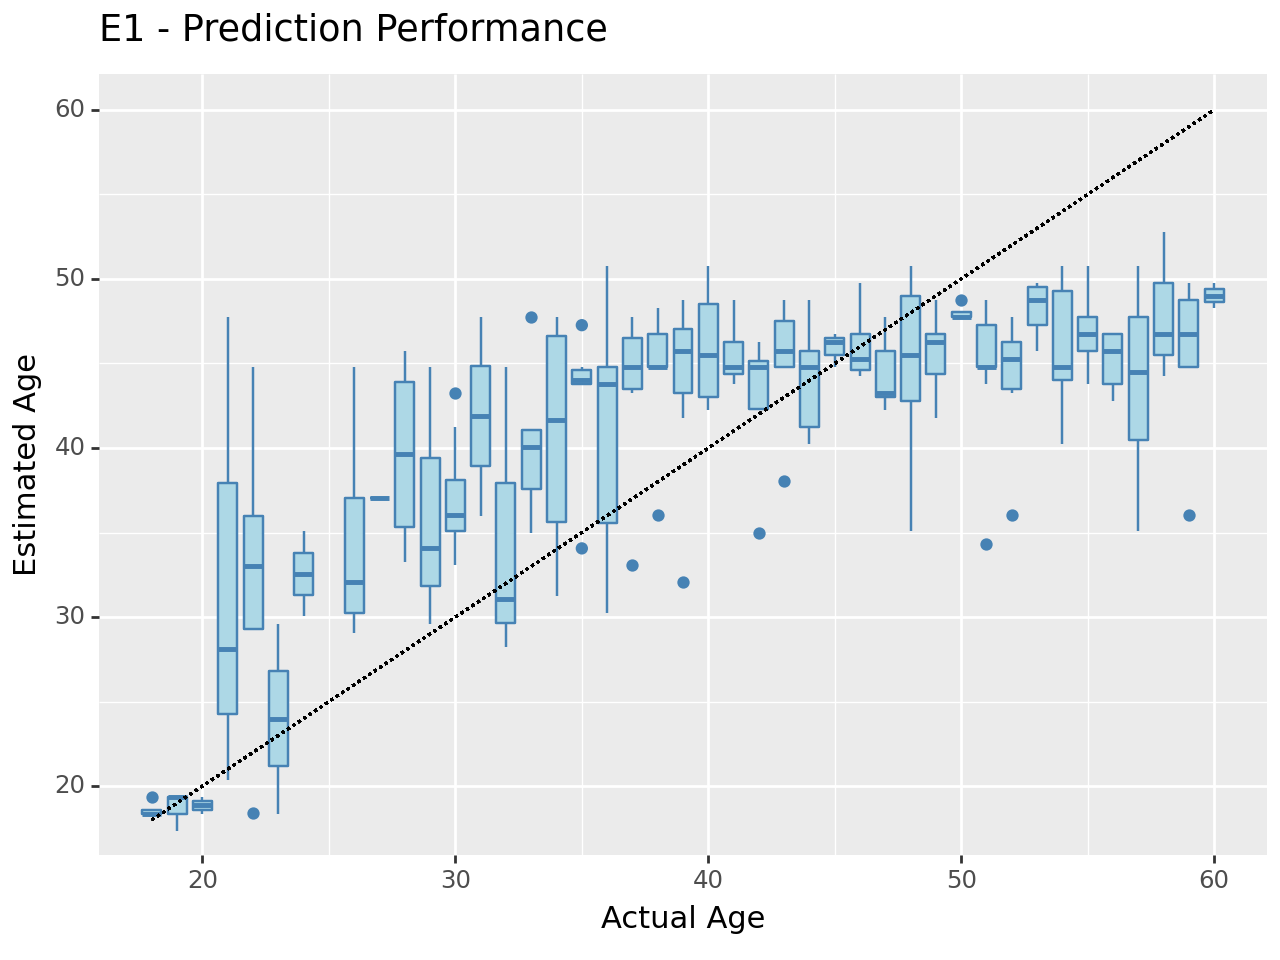

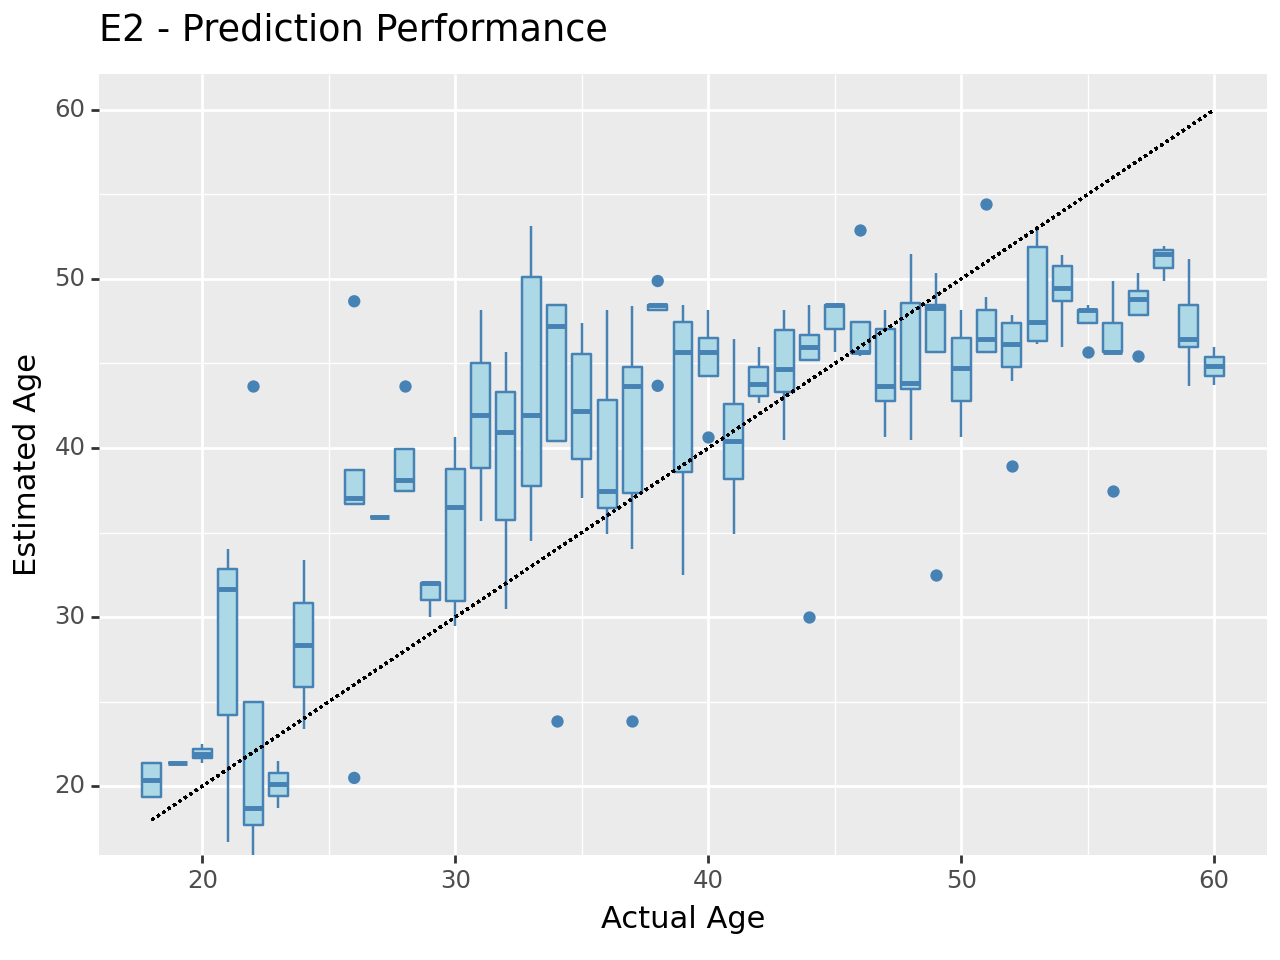

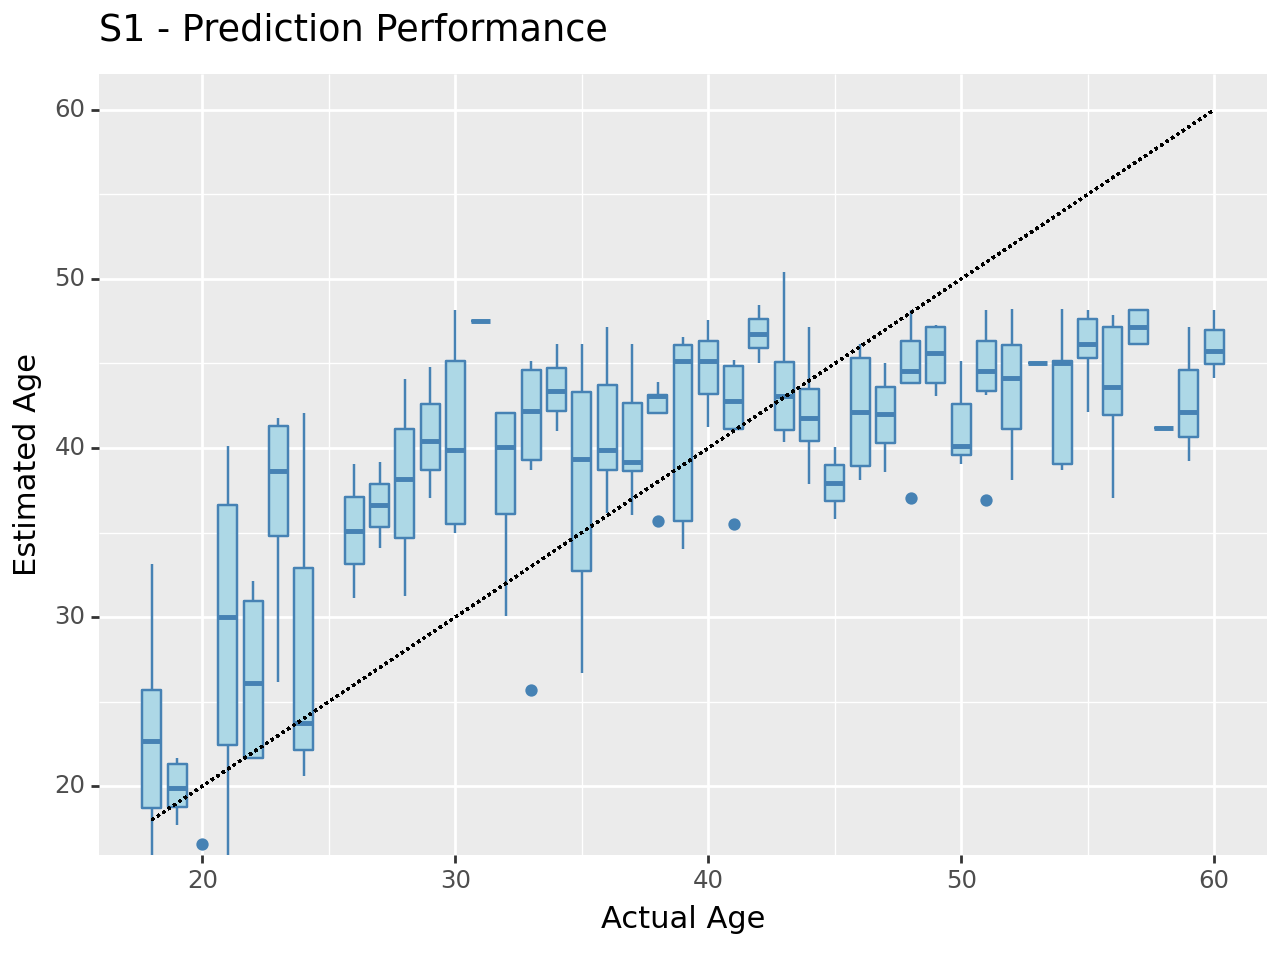

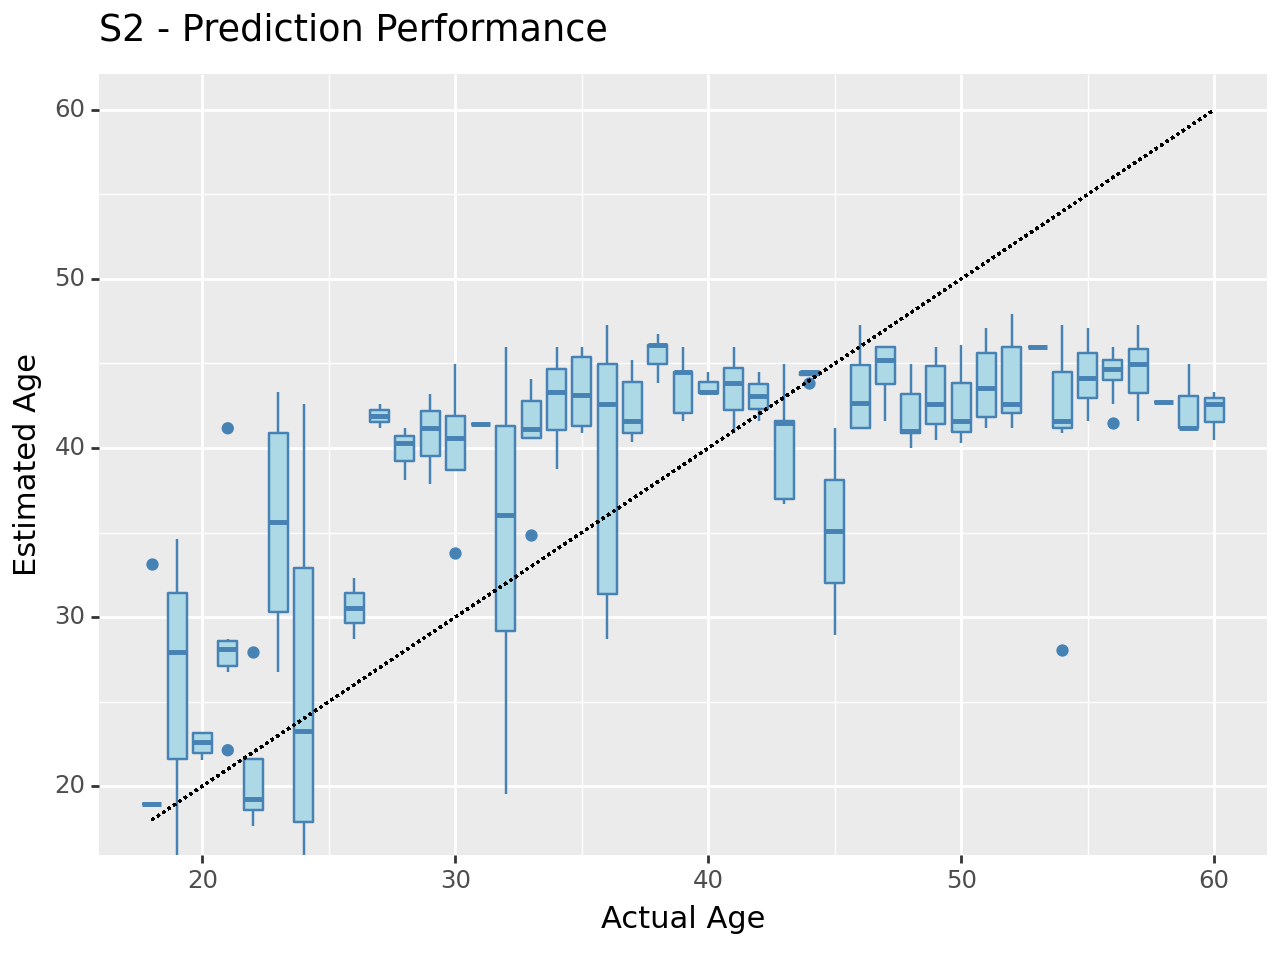

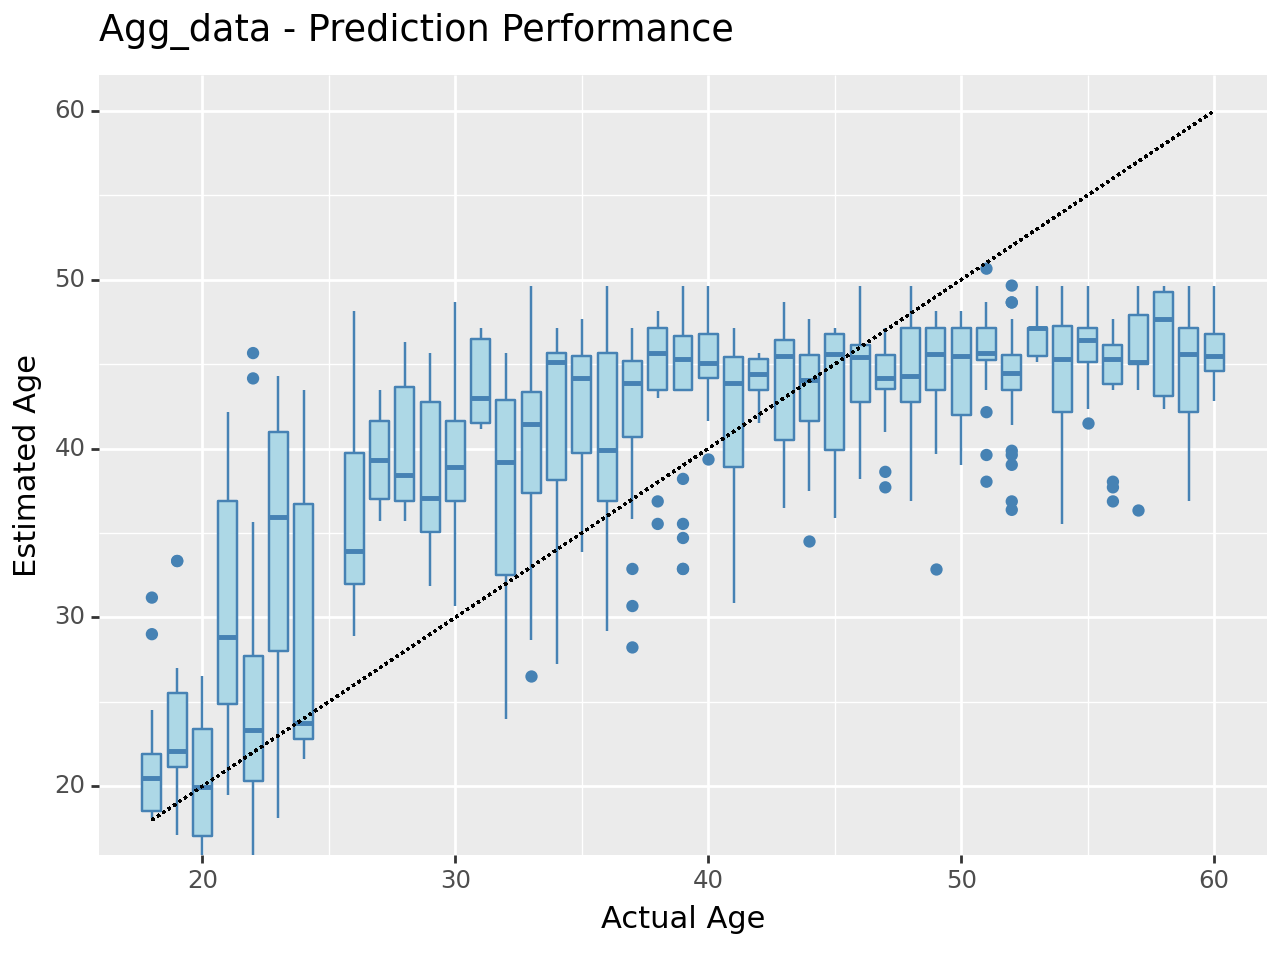

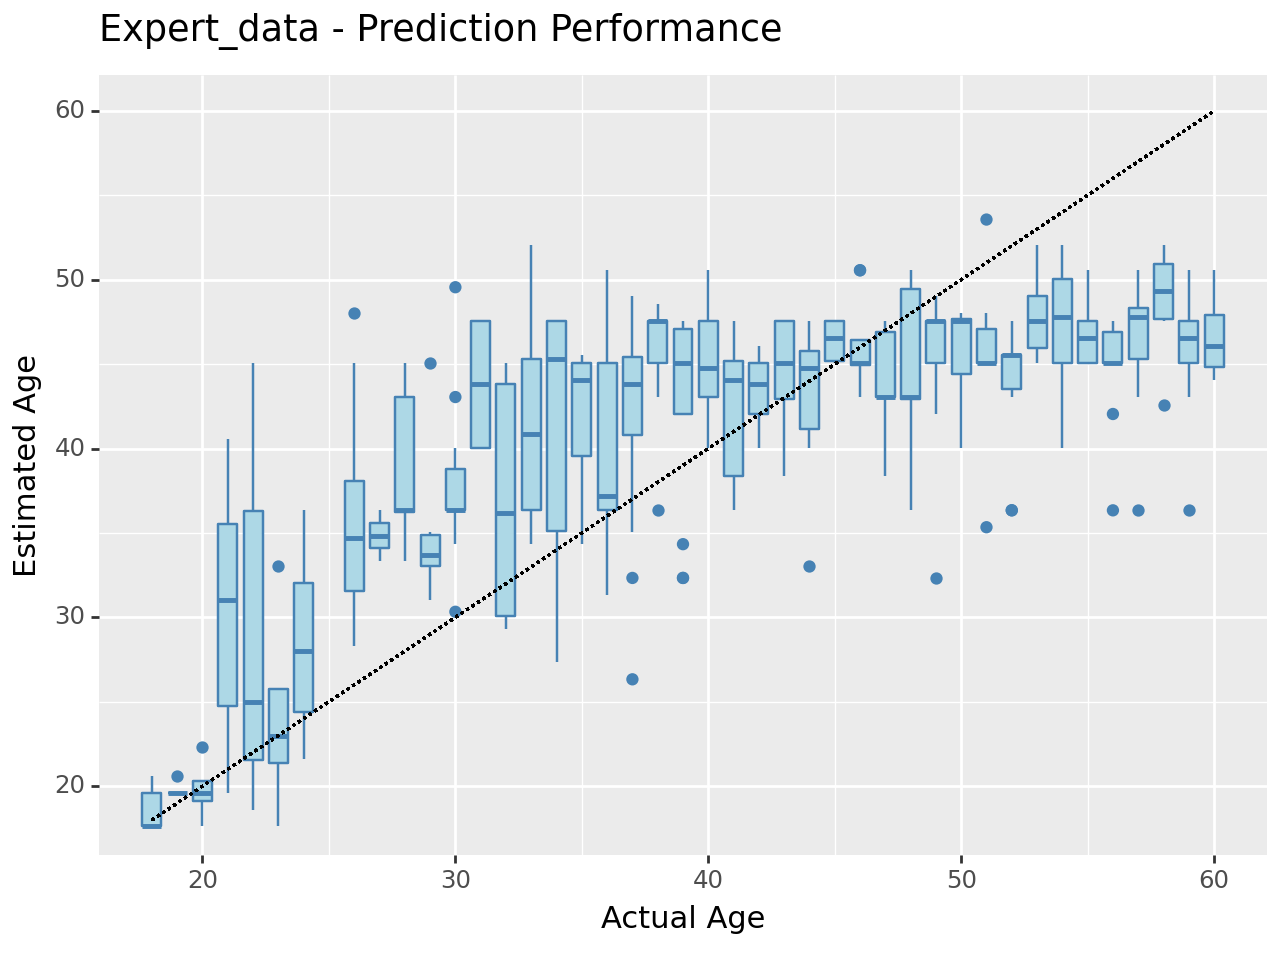

In [12]:

for sheet_name, df in  data_eval['X_train'].items():
     p=generate_plot(pd.DataFrame({'Age': data_eval['y_test'][sheet_name], 'prediction':SR_test_predictions[sheet_name]}),sheet_name)
     # Print the plot
     print(p)


# Ensembles

In [13]:
#Retrieval
test_pred_E1=SR_test_predictions['E1']
test_pred_E2=SR_test_predictions['E2']
test_pred_S1=SR_test_predictions['S1']
test_pred_S2=SR_test_predictions['S2']

### E1: Simple Average - Regression Voting

In [14]:

test_pred_ensemble1=(test_pred_E1+test_pred_S1+test_pred_S2+test_pred_E2)/4
test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensemble1)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble1)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble1,squared=False)
   
E1_test_results={'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating 4 labels',E1_test_results)

Aggregating 4 labels {'mae': 8.095358399524924, 'mse': 95.38294332244705, 'rmse': 9.766419165817481}


In [15]:
test_pred_ensemble1E=(test_pred_E1+test_pred_E2)/2
test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensemble1E)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble1E)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble1E,squared=False)
   
E1E_test_results={'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating Experts',E1E_test_results)

Aggregating Experts {'mae': 6.123749911122964, 'mse': 56.80960627633593, 'rmse': 7.537214755885355}


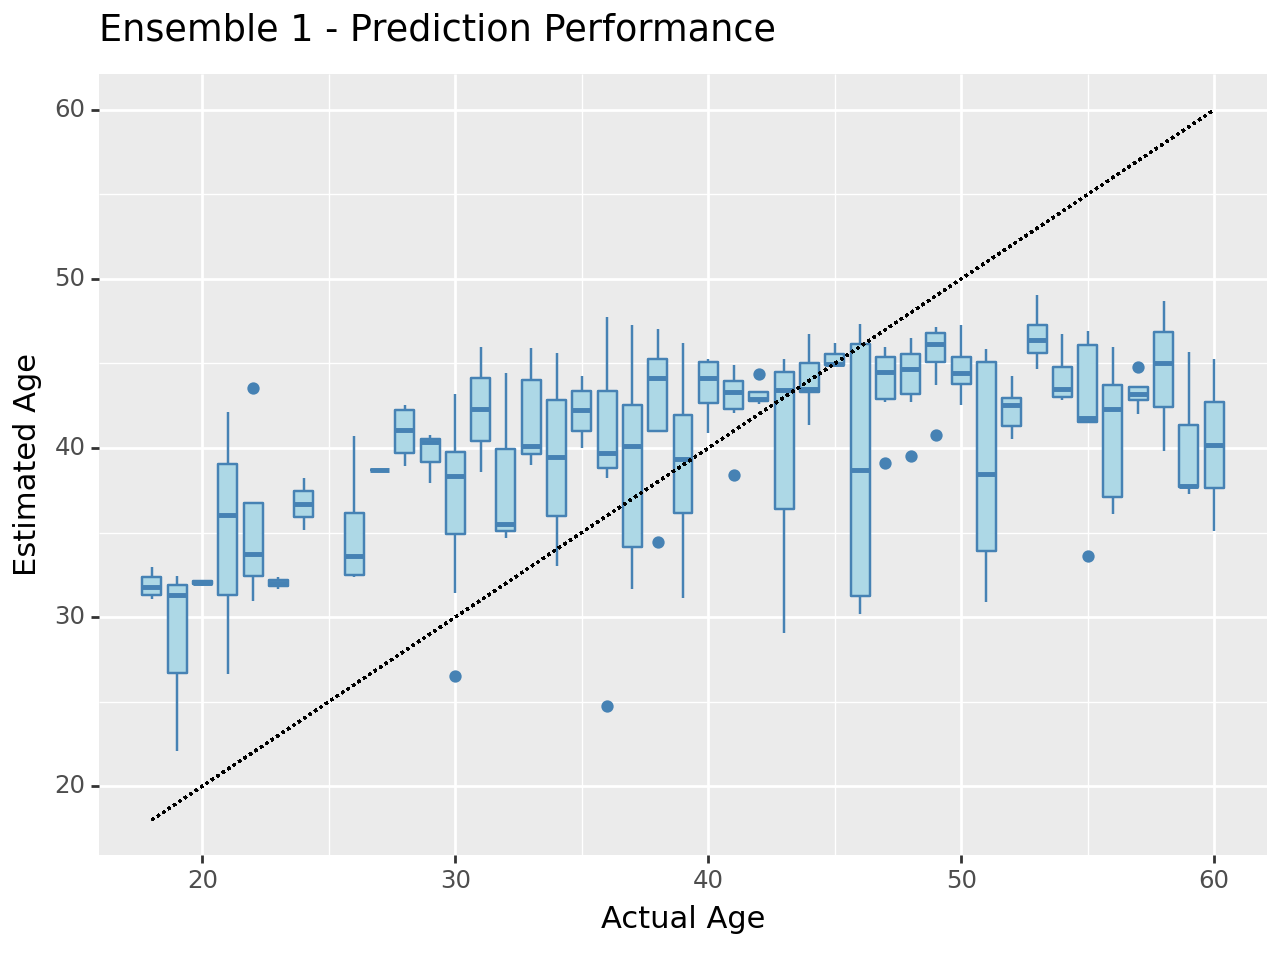

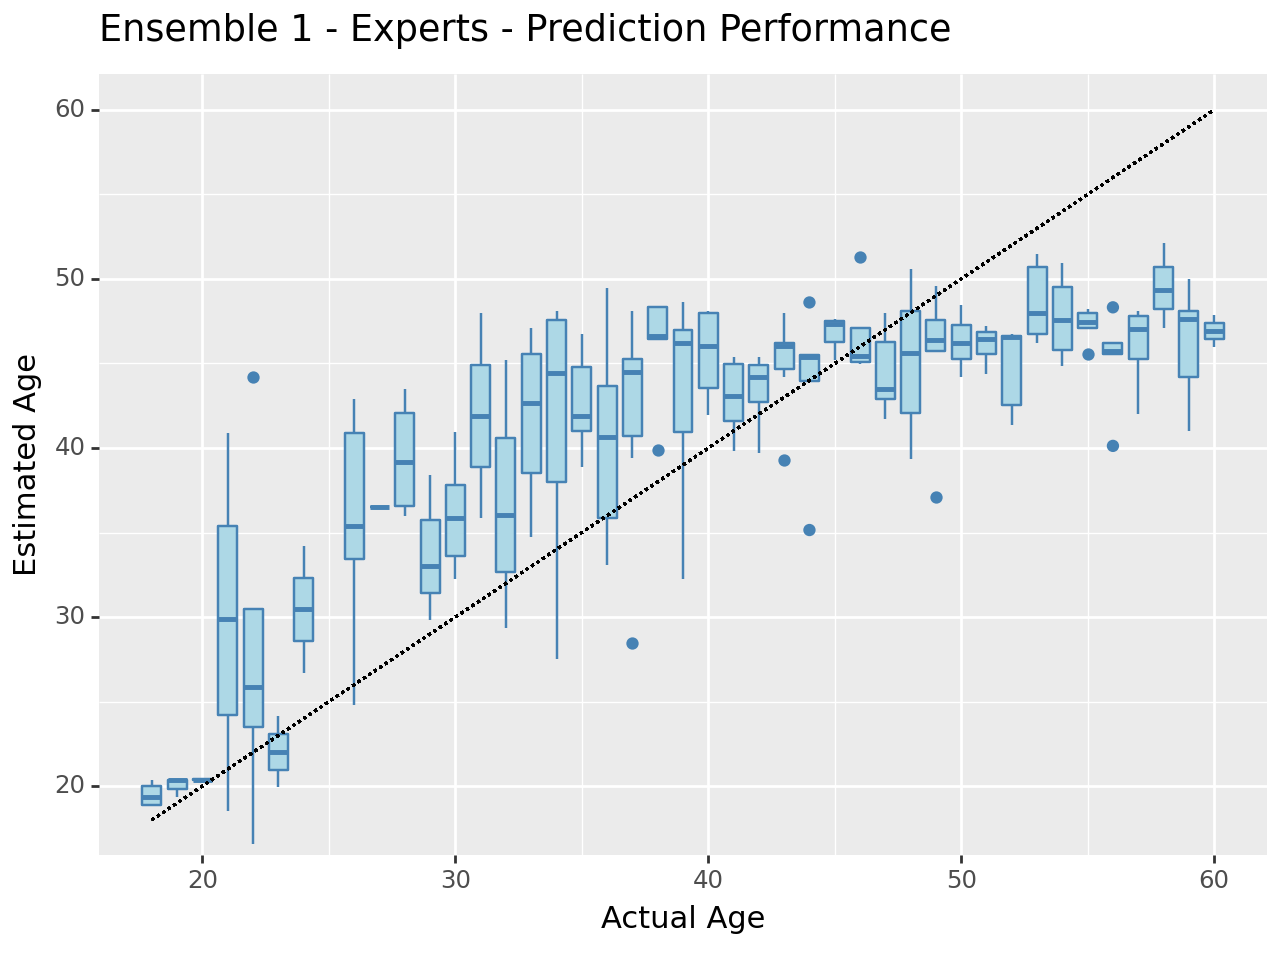

In [16]:

p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensemble1}),'Ensemble 1')
print(p)
p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensemble1E}),'Ensemble 1 - Experts')
print(p)


### E2: Weighted Average by Expertise

In [17]:

ws=np.array([2,1,1,2])
normalized_weights = normalize(ws.reshape(1, -1), norm='l1')[0]

test_pred_ensemble2=(test_pred_E1*normalized_weights[0]+test_pred_S1*normalized_weights[1]+test_pred_S2*normalized_weights[2]+test_pred_E2*normalized_weights[3])

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensemble2)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble2)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble2,squared=False)
   

E2_test_results={'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating 4 labels',E1_test_results)

Aggregating 4 labels {'mae': 8.095358399524924, 'mse': 95.38294332244705, 'rmse': 9.766419165817481}


In [18]:

ws=np.array([1,0,0,1])
normalized_weights = normalize(ws.reshape(1, -1), norm='l1')[0]

test_pred_ensemble2E=(test_pred_E1*normalized_weights[0]+test_pred_S1*normalized_weights[1]+test_pred_S2*normalized_weights[2]+test_pred_E2*normalized_weights[3])

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensemble2E)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble2E)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble2E,squared=False)
   
   

E2E_test_results={'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating Experts',E2E_test_results)

Aggregating Experts {'mae': 6.123749911122964, 'mse': 56.80960627633593, 'rmse': 7.537214755885355}


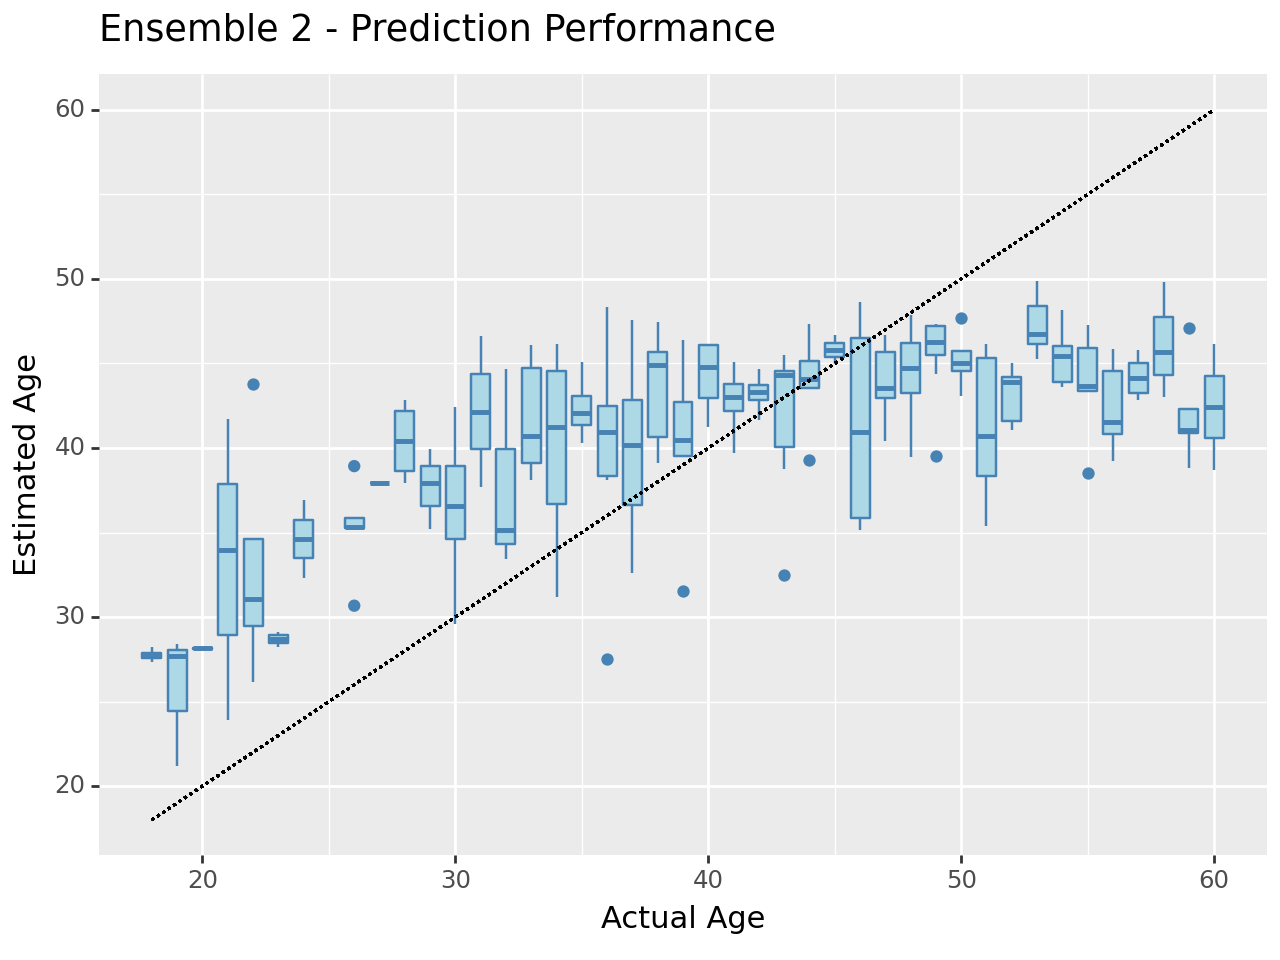

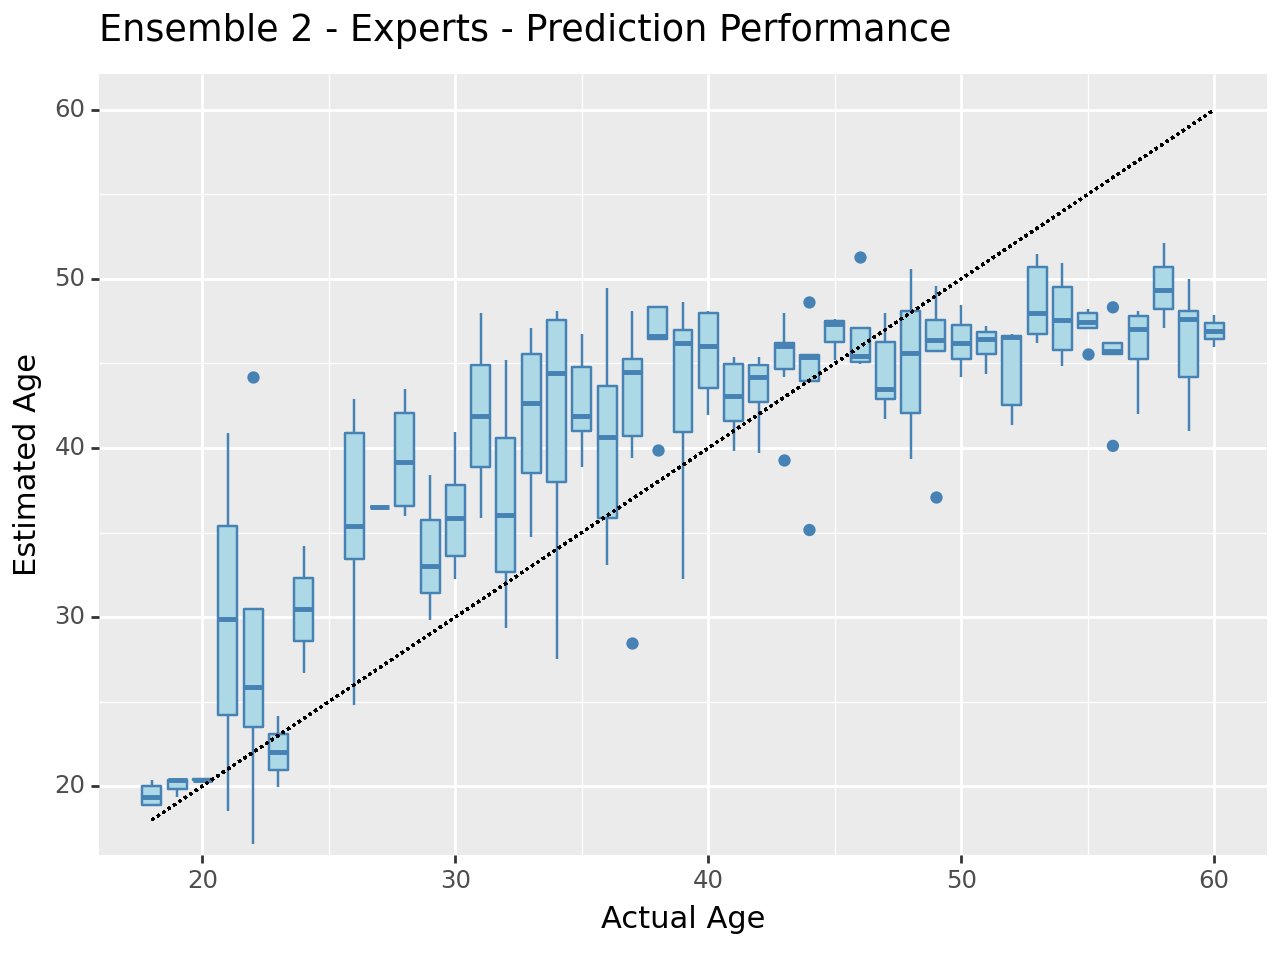

In [19]:


p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensemble2}),'Ensemble 2')
print(p)
p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensemble2E}),'Ensemble 2 - Experts')
print(p)

### E3: Weighted Average by validation score

In [21]:
scores={x: SR_train_results[x]['R2_score'] for x,y in  data_eval['X_train'].items()}

scores.pop('Agg_data')
scores.pop('Expert_data')


sorted_indices = sorted(scores, key=lambda k: scores[k])

sorted_idx=[sorted_indices.index(x)+1 for x in scores.keys()]

ws=np.array(sorted_idx)
normalized_weights = normalize(ws.reshape(1, -1), norm='l1')[0]
test_pred_ensemble3=(test_pred_E1*normalized_weights[0]+test_pred_S1*normalized_weights[1]+test_pred_S2*normalized_weights[2]+test_pred_E2*normalized_weights[3])

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensemble3)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble3)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble3,squared=False)
   

E3_test_results={'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating 4 labels',E3_test_results)

Aggregating 4 labels {'mae': 8.87483777651483, 'mse': 116.80881242000231, 'rmse': 10.807812564066898}


In [22]:
scores={'E1':SR_train_results['E1']['R2_score'],'E2':SR_train_results['E2']['R2_score']}



sorted_indices = sorted(scores, key=lambda k: scores[k])

sorted_idx=[sorted_indices.index(x)+1 for x in scores.keys()]

ws=np.array(sorted_idx)
normalized_weights = normalize(ws.reshape(1, -1), norm='l1')[0]
test_pred_ensemble3E=(test_pred_E1*normalized_weights[0]+test_pred_E2*normalized_weights[1])

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensemble3E)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble3E)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble3E,squared=False)
   

E3E_test_results={'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating Experts',E3E_test_results)

Aggregating Experts {'mae': 6.064168776635577, 'mse': 56.445451260227195, 'rmse': 7.5130187847646965}


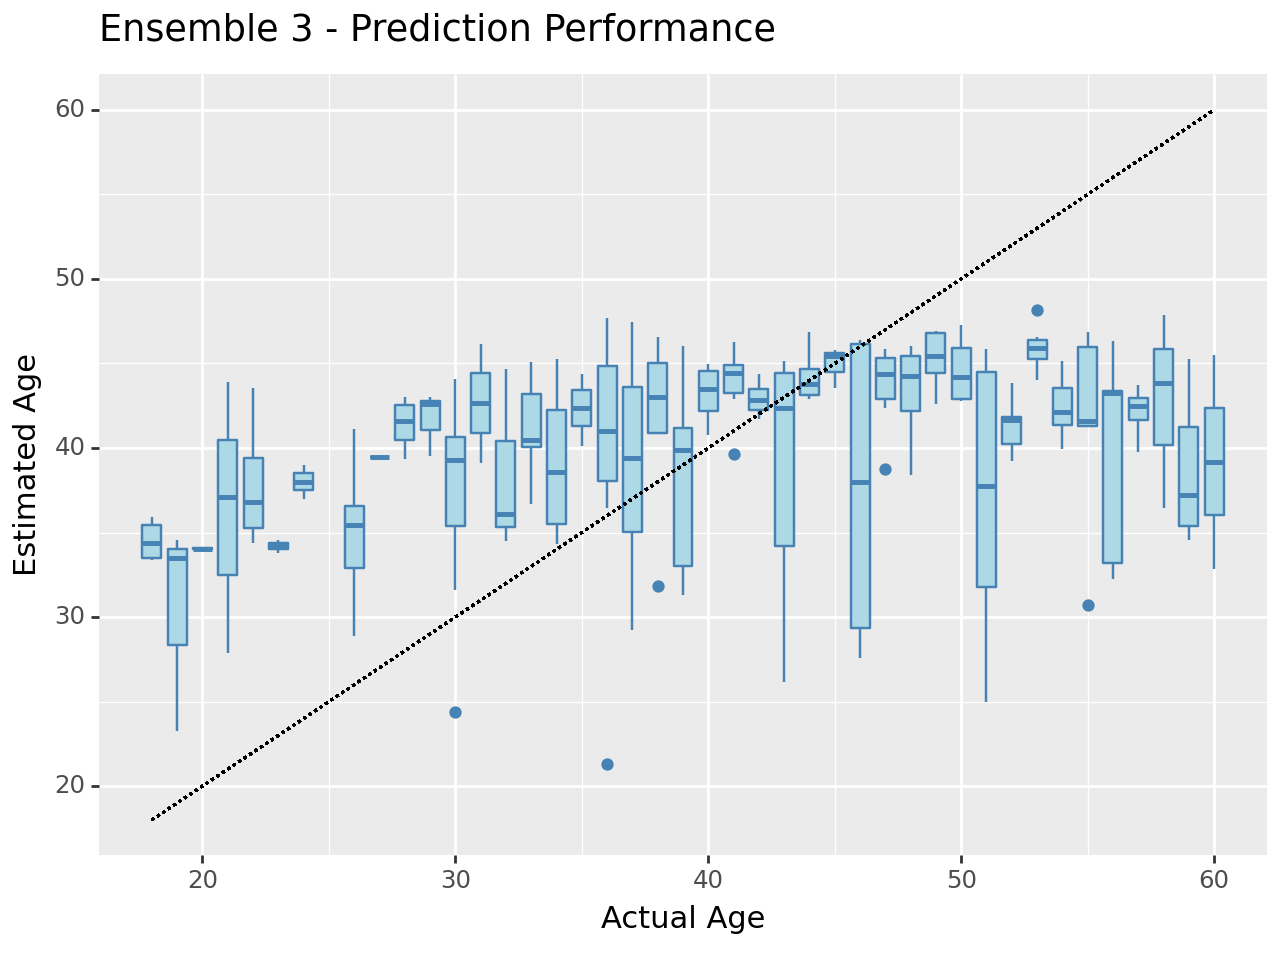

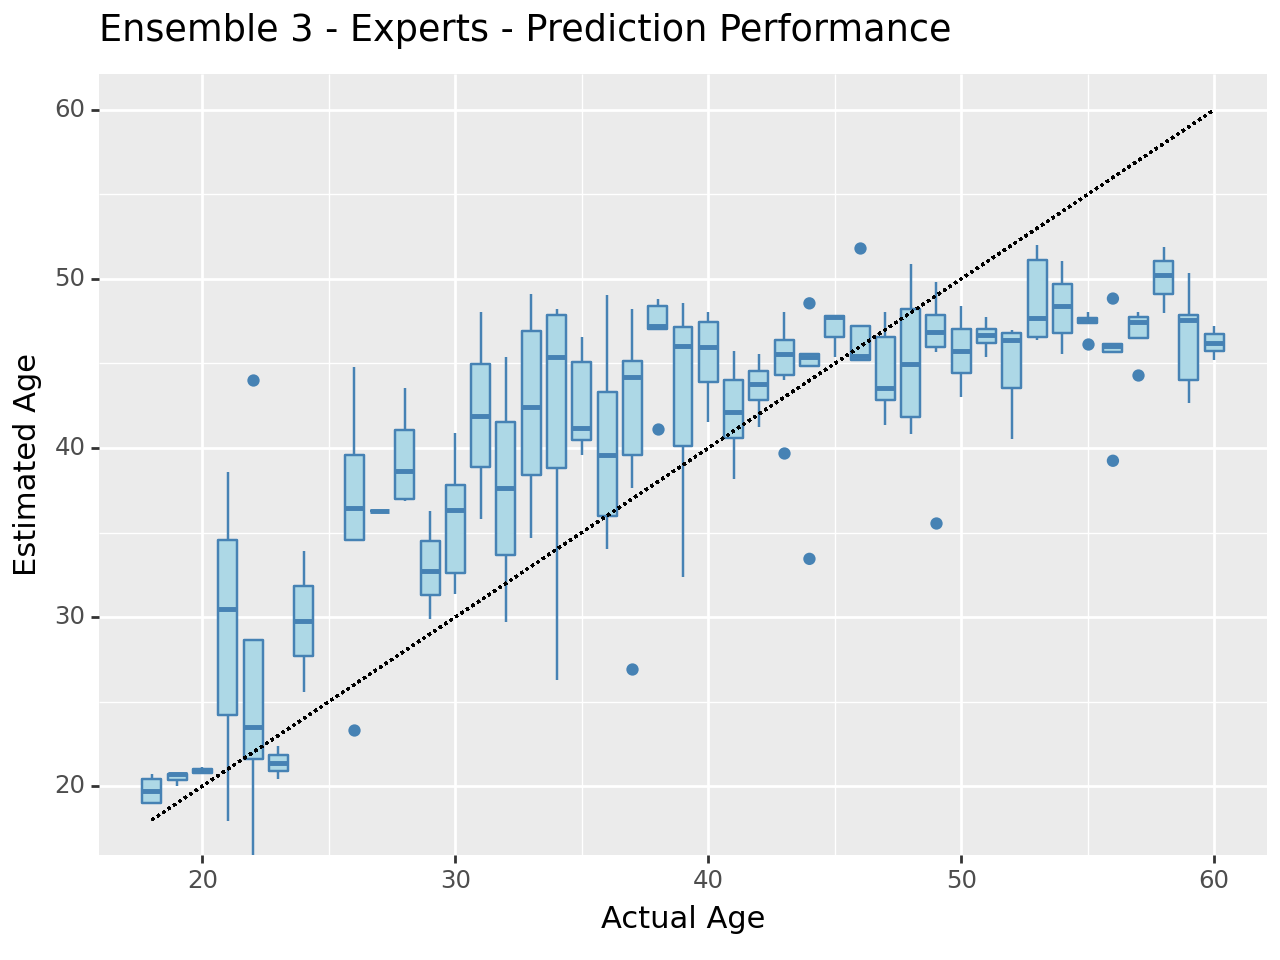

In [23]:


p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensemble3}),'Ensemble 3')
print(p)
p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensemble3E}),'Ensemble 3 - Experts')
print(p)

### E4: OWA

In [24]:

predictions=np.array([test_pred_E1,test_pred_S1,test_pred_S2,test_pred_E2])

test_pred_ensemble4=owas.OWA3(predictions,axis=0,keepdims=False)

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensemble4)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble4)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble4,squared=False)
   
E4_test_results={ 'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse }
print('Aggregating 4 labels',E4_test_results)

Aggregating 4 labels {'mae': 8.086774641609043, 'mse': 97.27791284597852, 'rmse': 9.862956597591744}


In [25]:


predictions=np.array([test_pred_E1,test_pred_E2])

test_pred_ensemble4E=owas.OWA3(predictions,axis=0,keepdims=False)

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensemble4E)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble4E)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble4E,squared=False)
   

E4E_test_results={ 'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse }
print('Aggregating Experts',E4E_test_results)

Aggregating Experts {'mae': 6.09088634083465, 'mse': 56.691984229545795, 'rmse': 7.529407960095256}


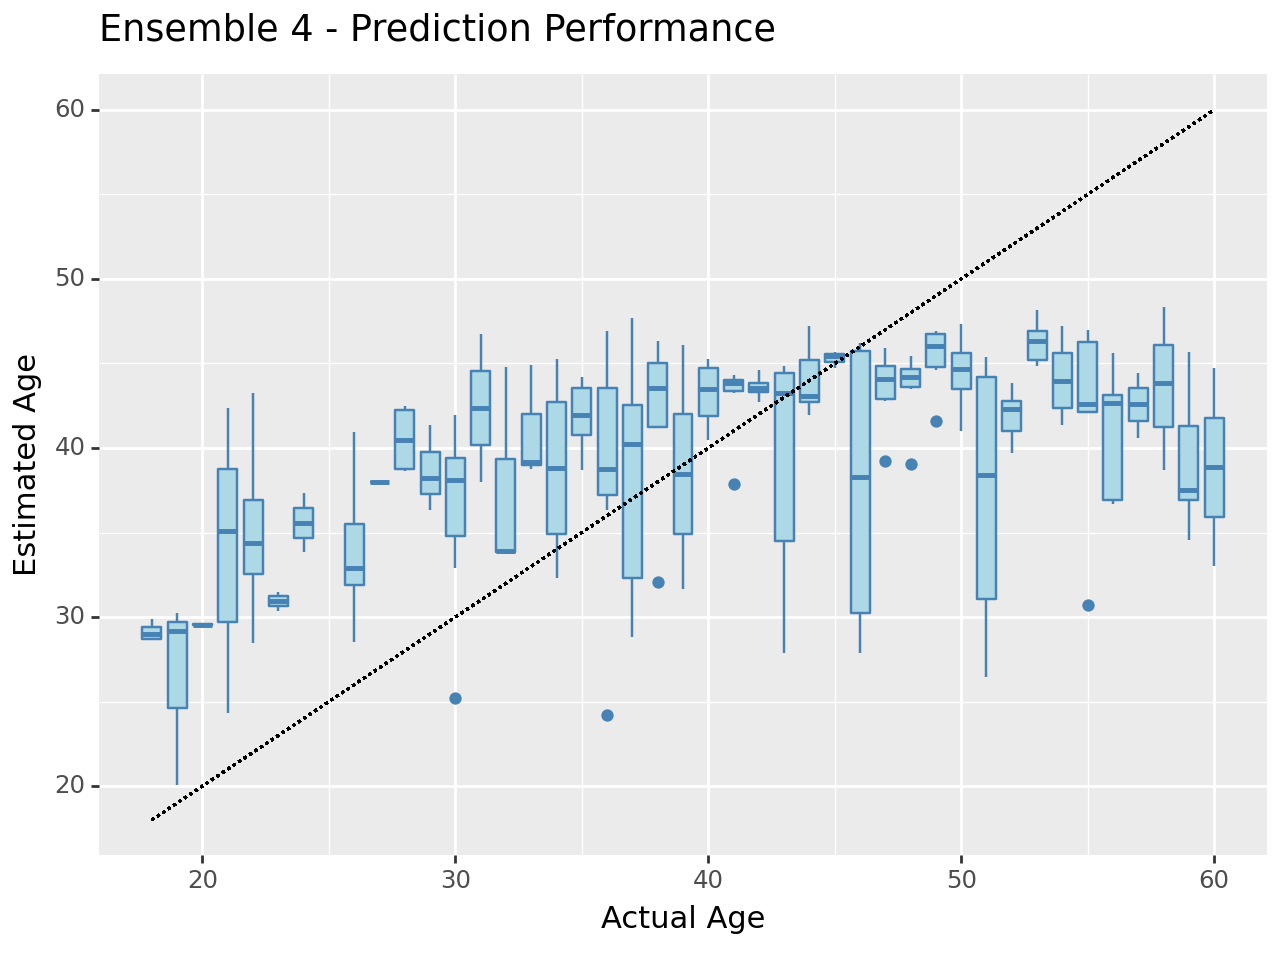

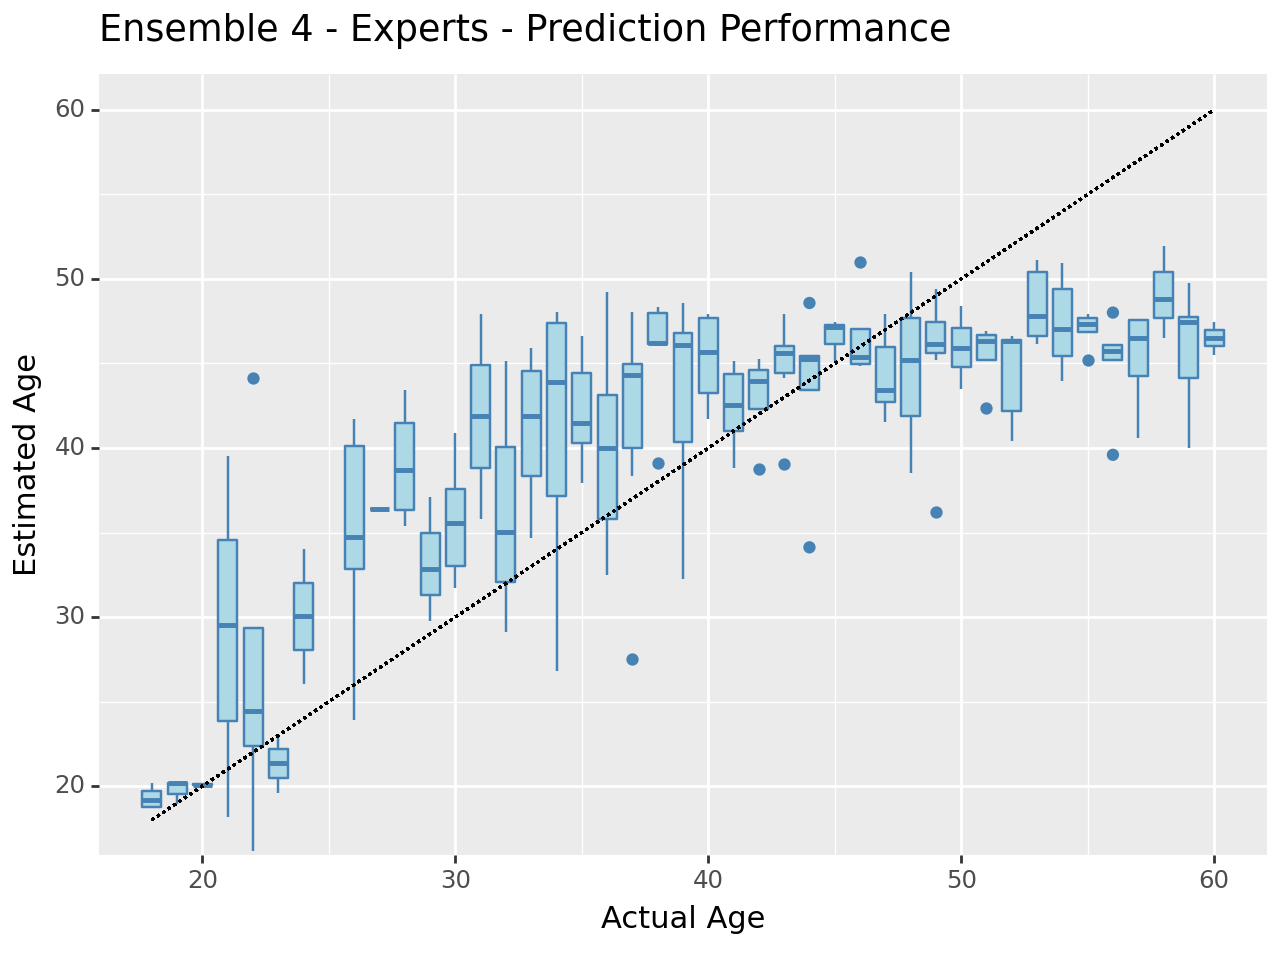

In [26]:


p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensemble4}),'Ensemble 4')
print(p)
p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensemble4E}),'Ensemble 4 - Experts')
print(p)


### E4.2: Fuzzy integral


In [27]:
predictions=np.array([test_pred_E1,test_pred_S1,test_pred_S2,test_pred_E2])
arr_t = predictions.T

test_pred_ensemble42=integrals.choquet_integral_CF(predictions,axis=0,keepdims=False)

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensemble42)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble42)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble42,squared=False)
   
E42_test_results={ 'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating 4 labels',E42_test_results)

Aggregating 4 labels {'mae': 8.994938499709916, 'mse': 152.14422676109038, 'rmse': 12.334675786622459}


In [28]:


predictions=np.array([test_pred_E1,test_pred_E2])

test_pred_ensemble42E=integrals.choquet_integral_CF(predictions,axis=0,keepdims=False)

test_metric_mae=metrics.mean_absolute_error(data_eval['y_test']['E1'],test_pred_ensemble42E)
test_metric_mse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble42E)
test_metric_rmse=metrics.mean_squared_error(data_eval['y_test']['E1'],test_pred_ensemble42E,squared=False)
   
E42E_test_results={ 'mae':test_metric_mae,'mse':test_metric_mse,'rmse':test_metric_rmse}
print('Aggregating Experts',E42E_test_results)

Aggregating Experts {'mae': 6.186679991303427, 'mse': 59.57804836618567, 'rmse': 7.718681776455464}


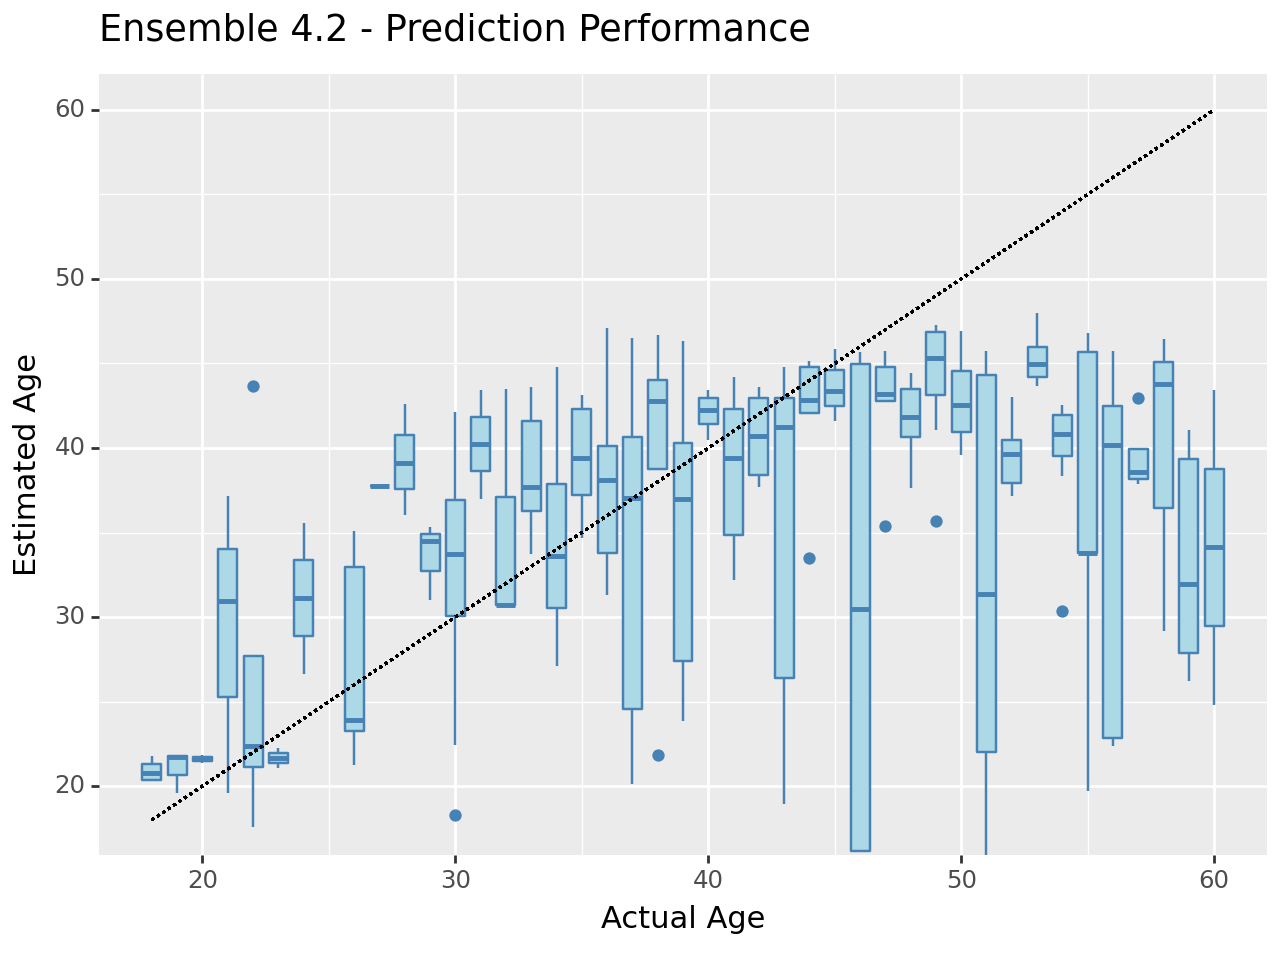

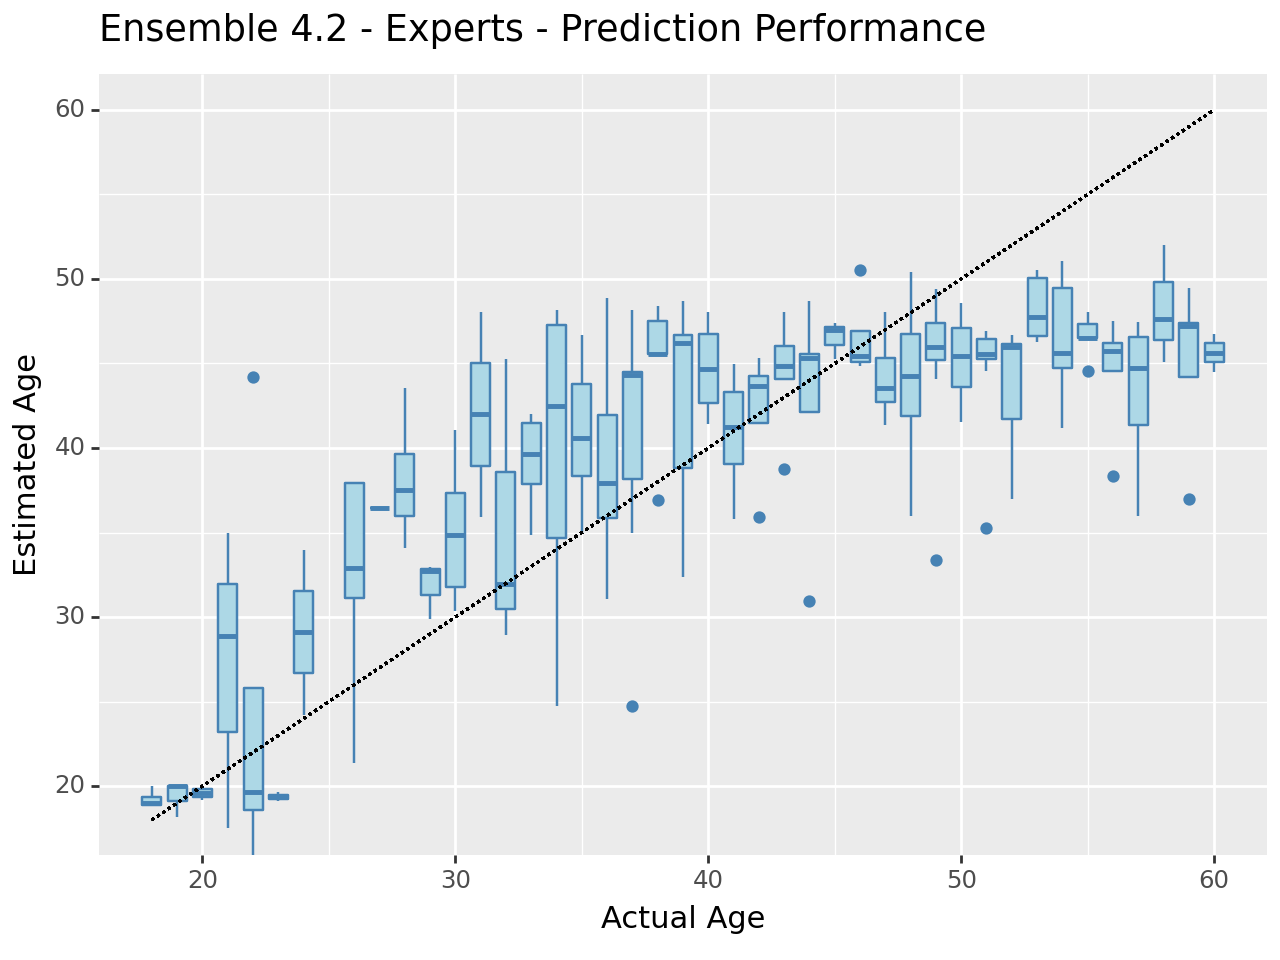

In [32]:

p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensemble42}),'Ensemble 4.2')
print(p)
p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':test_pred_ensemble42E}),'Ensemble 4.2 - Experts')
print(p)



### Summary

In [30]:
print("Base - Expert 1:                     ",SR_test_results['E1'])
print("Base - Expert 2:                     ",SR_test_results['E2'])
print("Base - Student 1 :                   ",SR_test_results['S1'])
print("Base - Student 2 :                   ",SR_test_results['S2'])
print("Aggregated:                          ",SR_test_results['Agg_data'])
print("Experts:                             ",SR_test_results['Expert_data'])

print("Ensembles all weak learners:")
print('E1 - Simple average:                 ',E1_test_results)
print('E2 - weighted average:               ',E2_test_results)
print('E3 - weights by score rank:          ',E3_test_results)
print('E4 - OWA3:                           ',E4_test_results)

print('Ensembles with only two experts')
print('E1 - Simple average:                 ',E1E_test_results)
print('E3 - weights by score rank:          ',E3E_test_results)
print('E4 - OWA3:                           ',E4E_test_results)





Base - Expert 1:                      {'mae': 6.600629688890123, 'rmse': 8.19381648740815}
Base - Expert 2:                      {'mae': 6.196953602084004, 'rmse': 7.767587777446707}
Base - Sutdent 1 :                    {'mae': 7.396851227833544, 'rmse': 8.854312704047723}
Base - Student 2 :                    {'mae': 7.832577505890155, 'rmse': 9.224244120703329}
Aggregated:                           {'mae': 7.065357327526196, 'rmse': 8.49433658588078}
Experts:                              {'mae': 6.400653697000562, 'rmse': 7.965749547581945}
Ensembles all weak learners:
E1 - Simple average:                  {'mae': 8.095358399524924, 'mse': 95.38294332244705, 'rmse': 9.766419165817481}
E2 - weighted average:                {'mae': 7.206000700039375, 'mse': 74.93789543311158, 'rmse': 8.656667686420196}
E3 - weights by score rank:           {'mae': 8.87483777651483, 'mse': 116.80881242000231, 'rmse': 10.807812564066898}
E4 - OWA3:                            {'mae': 8.086774641609043, '

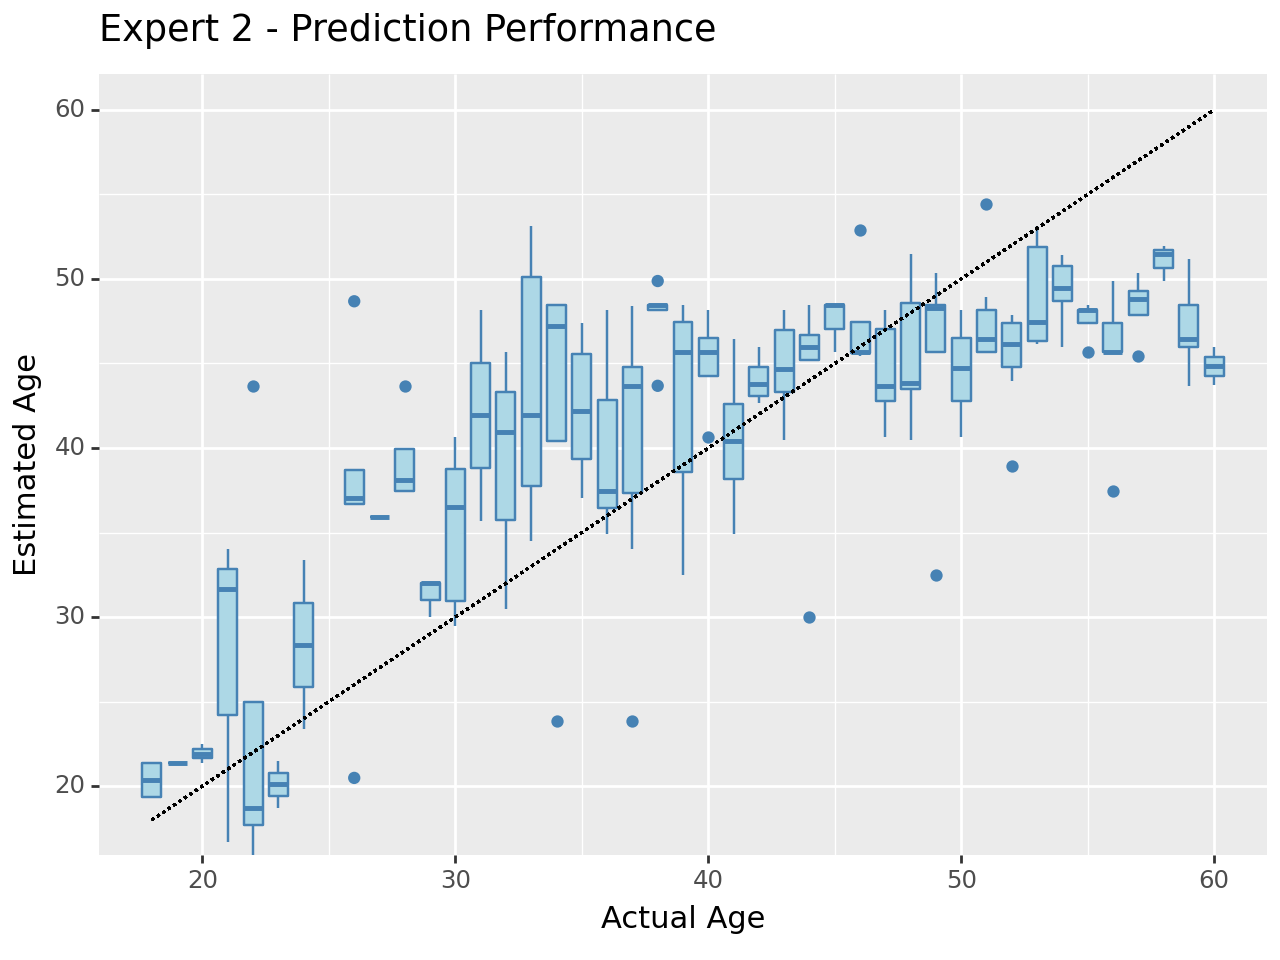

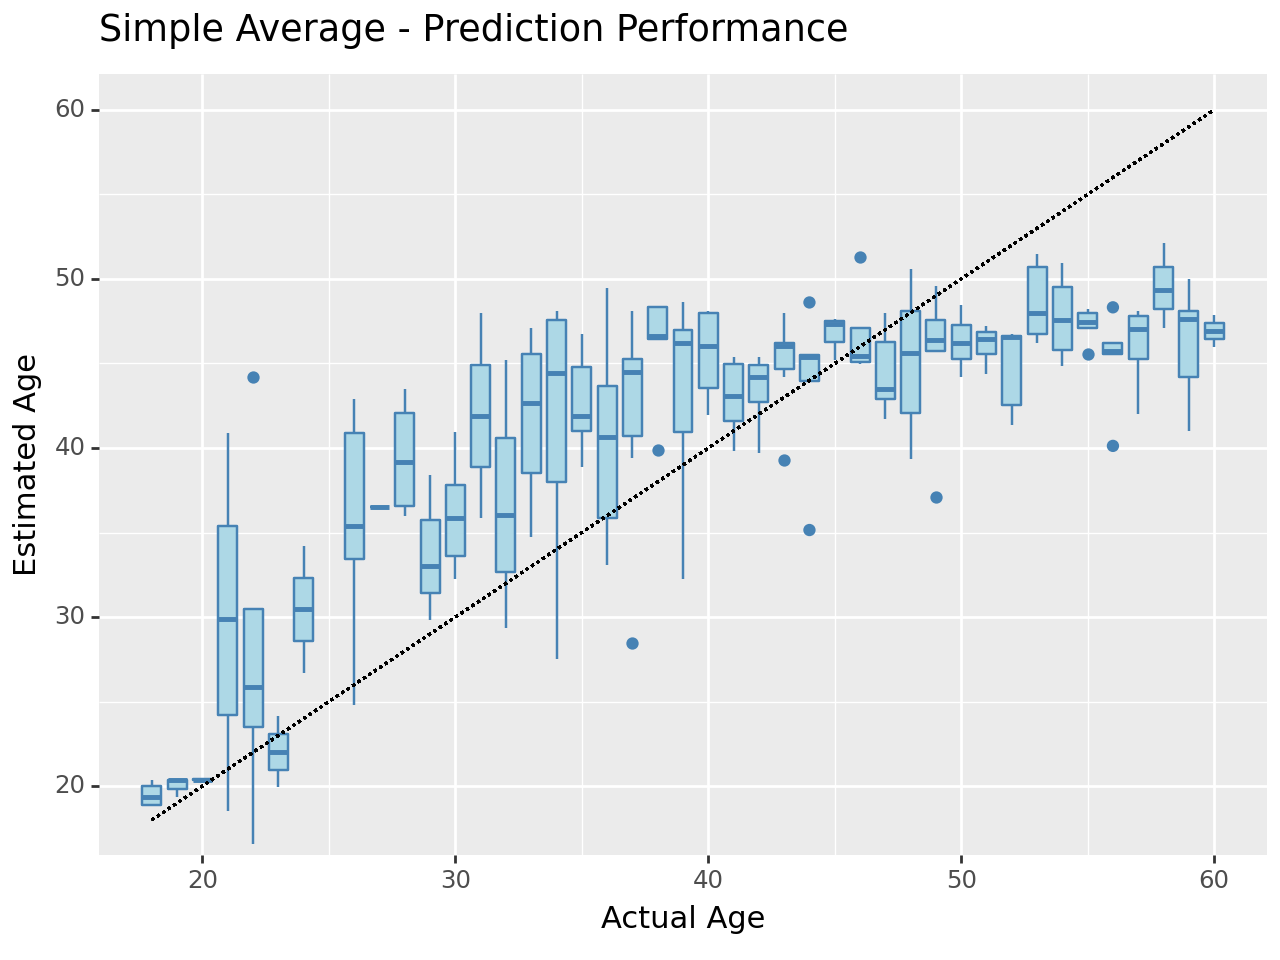

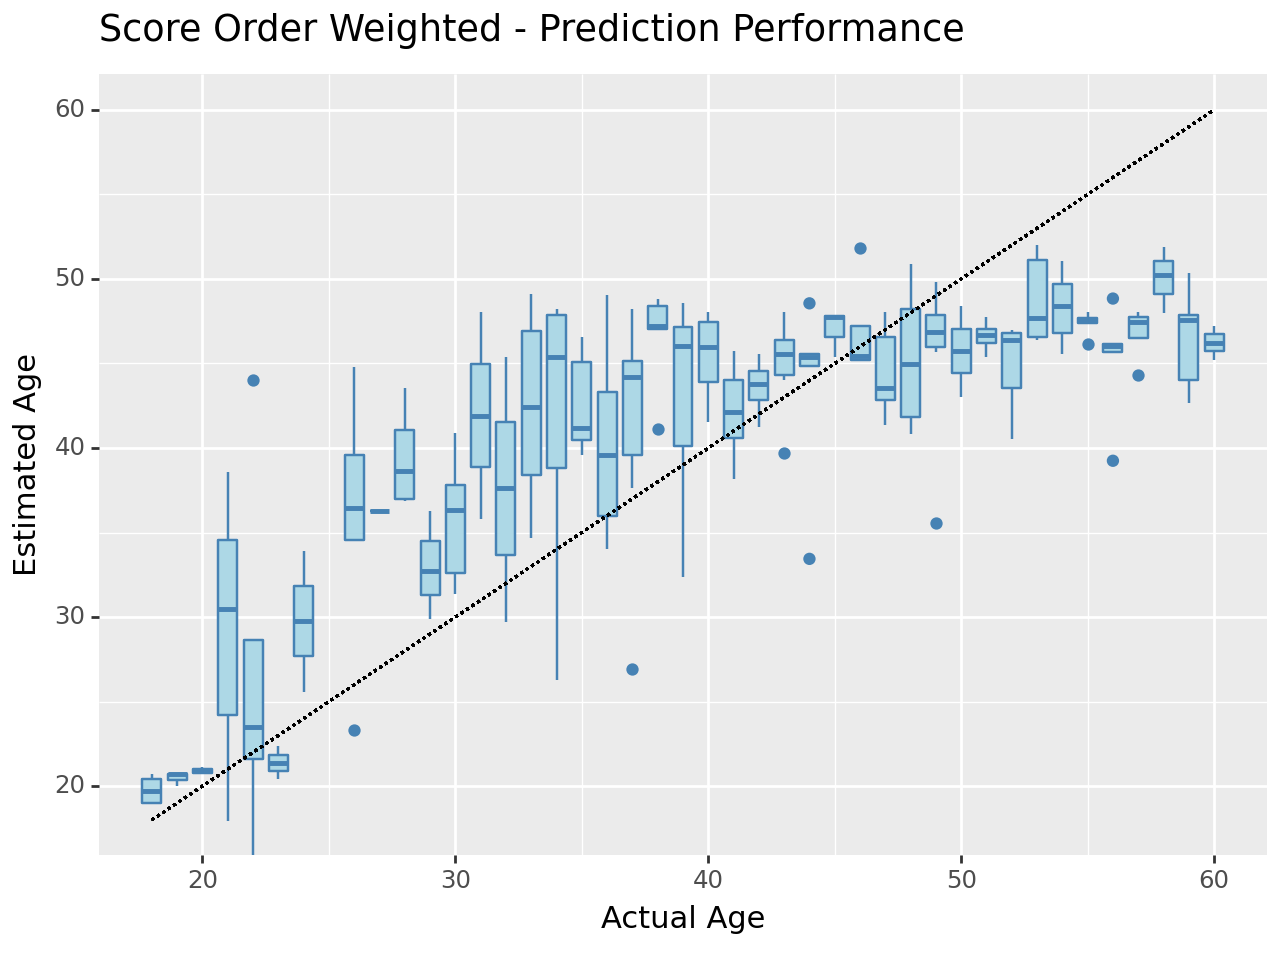

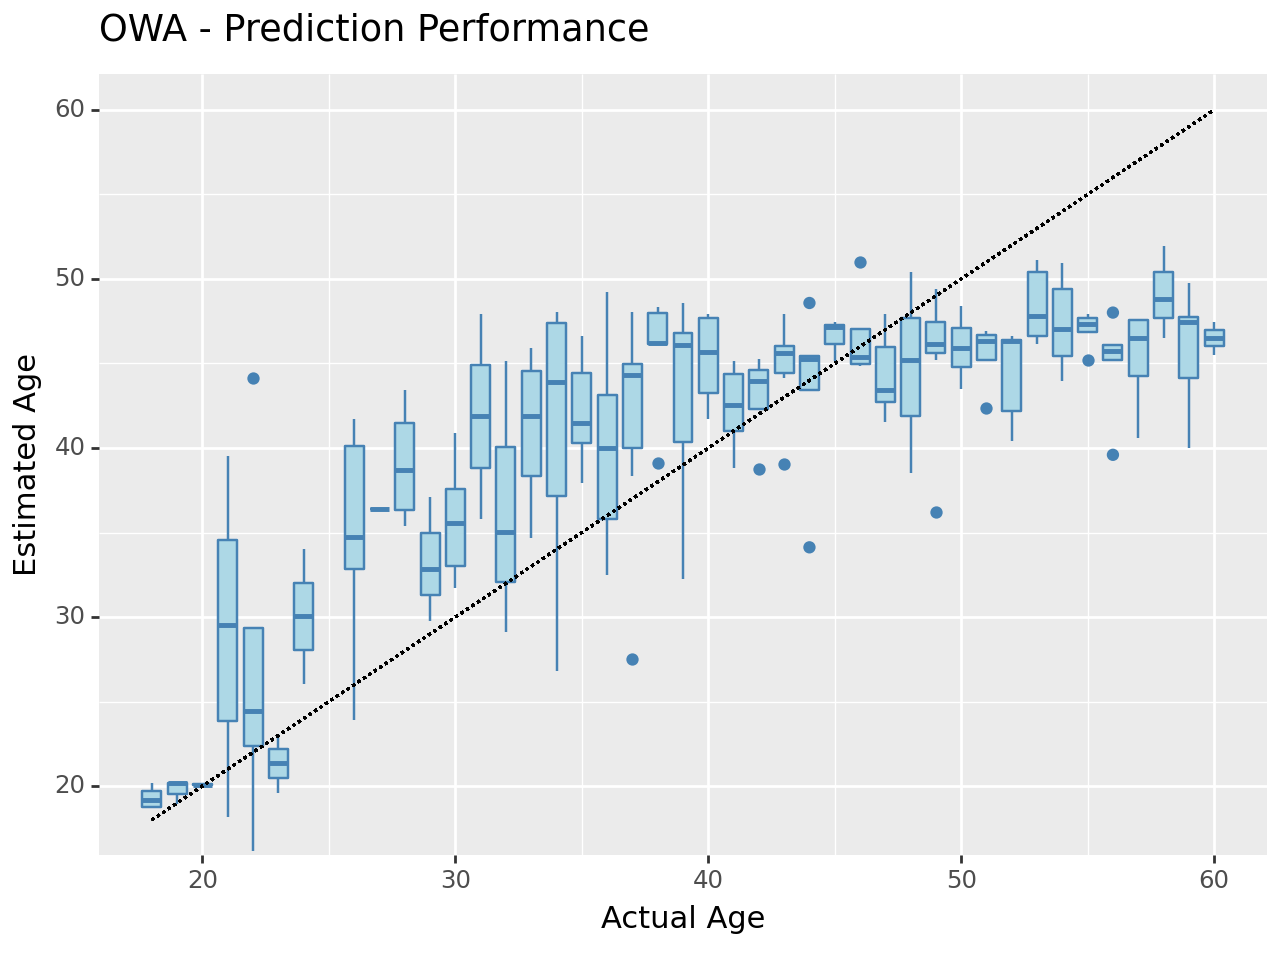

In [35]:

best=[SR_test_predictions['E2'],test_pred_ensemble1E,test_pred_ensemble3E,test_pred_ensemble4E]
names=['Expert 2', 'Simple Average','Score Order Weighted','OWA']
for i in range(len(best)):
    p=generate_plot(pd.DataFrame({'Age': data_eval['y_test']['E1'], 'prediction':best[i]}),names[i])
    print(p)
